# 1. Import Library

In [1]:
# J Patel คือชื่อคน
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Write Function

In [2]:
# Random ค่า Weight และ bias (กรณีโจรทย์ไม่ได้กำหนดให้)
def NN_create_WB(A0, HL):
    W = []
    B = []
    for i in range(len(HL)):
        if i == 0: #Layer แรก (Input)
            W_i = np.random.randn(A0.shape[1], HL[0])/np.sqrt(HL[0]) # matrix (A0.shape[1], HL[0]) หารจำนวน Layer ทั้งหมด np.sqrt(HL[0])
        else:
            W_i = np.random.randn(HL[i-1], HL[i])/np.sqrt(HL[i]) #HL[i-1] Layerก่อนหน้า
        
        B_i = np.random.randn(1, HL[i])/np.sqrt(HL[i])
        W.append(W_i)
        B.append(B_i)
    return W, B

In [3]:
#=================== Regression =======================#
def NNR_find_WB(A0, T, HL, AF, epoch = 1000, lr = 0.01):
    L = len(HL)
    N = A0.shape[0]
    W, B = NN_create_WB(A0, HL)
    error_list = []
    for i in range(epoch):
        
        #------- forward ---------#
        Z, A = NN_forward(A0, W, B, AF)
        error = find_error(T, A[-1], 'SSE') #เทียบคำตอบจริง(T) กับค่าที่ได้ใน node Layer A
        error_list.append(error) #Add matraix ใน error_list
        
        #----- backpropagation ----#
        #---- W(m) = W(m) + ( (α/N) * A(m-1)^T *Err(m)) -----#
        SW, SB = NNR_backpropagation(A0, W, B, Z, A, T, AF)
        for j in range(L):
            W[j] = W[j] + (lr/N)*SW[j] # W(m) = W(m) + (α* A(m-1)^T *Err(m))/N
            B[j] = B[j] + (lr/N)*SB[j] # B(m) = B(m) + (α* Err(m).sum(axis=0))/N
            
    return W, B, error_list

In [4]:
#============== Classification (Error -> Entropy) ====================#
def NNC_find_WB(A0, T, HL, AF, epoch = 1000, lr = 0.01):
    L = len(HL)
    N = A0.shape[0]
    W, B = NN_create_WB(A0, HL)
    error_list = []
    for i in range(epoch):
        
        #------- forward ---------#
        Z, A = NN_forward(A0, W, B, AF)
        error = find_error(T, A[-1], 'Entropy') #เทียบคำตอบจริง(T) กับค่าที่ได้ใน node Layer A
        error_list.append(error) #Add matraix ใน error_list
        
        #----- backpropagation ----#
        #---- W(m) = W(m) + ( (α/N) * A(m-1)^T *Err(m)) -----#
        SW, SB = NNC_backpropagation(A0, W, B, Z, A, T, AF)
        for j in range(L):
            W[j] = W[j] + (lr/N)*SW[j] # W(m) = W(m) + (α* A(m-1)^T *Err(m))/N
            B[j] = B[j] + (lr/N)*SB[j] # B(m) = B(m) + (α* Err(m).sum(axis=0))/N
            
    return W, B, error_list

In [5]:
def NN_forward(A0, W, B, AF):
    Z = []
    A = []
    for i in range(len(AF)):
        
        if i == 0: #Layer แรก (Input)
            Z_i = np.dot(A0, W[i]) + B[i] #A0W1 + B1
        else: #Layer ถัดๆไป
            Z_i = np.dot(A[-1], W[i]) + B[i]
            
        A_i = NN_compute_A(Z_i, AF[i]) #Activation function
        Z.append(Z_i)
        A.append(A_i)
    return Z, A

In [6]:
#Activation function
def NN_compute_A(Z_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            A_i = 1/(1 + np.exp(-Z_i))
        elif af == 'tanh':
            A_i = (np.exp(Z_i) - np.exp(-Z_i))/(np.exp(Z_i) + np.exp(-Z_i))
        elif af == 'ReLU':
            A_i = Z_i * (Z_i > 0)
        elif af == 'softmax':
            A_i = np.exp(Z_i)/np.exp(Z_i).sum(axis=1, keepdims = True)
    elif type(af) == list:
        if af[0] == 'PReLU':
            A_i = Z_i * (Z_i > 0) + af[1] * Z_i * (Z_i <= 0)
    return A_i

In [7]:
#=================== Regression =======================#
#---- W(m) = W(m) + (α* A(m-1)^T *Err(m))/N -----#
def NNR_backpropagation(A0, W, B, Z, A, T, AF):
    L = len(AF)
    SW = []
    SB = []
    for i in range(L - 1, -1, -1): #ย้อนกลับทีละหนึ่ง Step หลังไปหน้า (out -> in) (-1)
        if i == L - 1:
            Delta_i = T - A[i] #layer แรก (output) δ(m) = T - A(m)
        else:
            Delta_i = np.dot(Err_i, W[i+1].T) # δ(m) = Err(m+1)*W(m+1)^T
            
        Diff_i = NN_compute_Diff(Z[i], A[i], AF[i]) # Diff -> Activation function
        Err_i = NN_compute_Err(Delta_i, Diff_i) #Err(m+1) = δ(m) * Diff(m)
        
        #---- W(m) ---#
        if i != 0:
            SW_i = np.dot(A[i-1].T, Err_i) #layer ต่อๆมา # W(m) = A(m-1)^T *Err(m)
        else:
            SW_i = np.dot(A0.T, Err_i) #layer แรก (output) # W(1) = A(0)^T *Err(1)
        
        SB_i = Err_i.sum(axis=0) #รวมกันแนวตั้ง
        SW.append(SW_i) # Err_i -> SW_i -> SW -> W(m) or Wight
        SB.append(SB_i) # bias
    return SW[::-1], SB[::-1] # -1 กลับด้าน Array matrix ให้เรียง forward

In [8]:
#---- W(m) = W(m) + (α* A(m-1)^T *Err(m))/N -----#
def NNC_backpropagation(A0, W, B, Z, A, T, AF):
    L = len(AF)
    SW = []
    SB = []
    for i in range(L - 1, -1, -1):  #ย้อนกลับทีละหนึ่ง Step หลังไปหน้า (out -> in) (-1)
        
        if i == L - 1:
            Delta_i = T - A[i] #layer แรก (output) δ(m) = T - A(m)
            Diff_i = 1         # Diff_i = 1 ตามการ Diff simoid function ใน layer แรก (output)
        else:
            Delta_i = np.dot(Err_i, W[i+1].T)  # δ(m) = Err(m+1)*W(m+1)^T
            Diff_i = NN_compute_Diff(Z[i], A[i], AF[i])  # Diff -> Activation function       
        
        Err_i = NN_compute_Err(Delta_i, Diff_i) #Err(m+1) = δ(m) * Diff(m)
        
        #---- W(m) ---#
        if i != 0:
            SW_i = np.dot(A[i-1].T, Err_i) #layer ต่อๆมา # W(m) = A(m-1)^T *Err(m)
        else:
            SW_i = np.dot(A0.T, Err_i) #layer แรก (output) # W(1) = A(0)^T *Err(1)
        
        SB_i = Err_i.sum(axis=0) #รวมกันแนวตั้ง
        SW.append(SW_i) # Err_i -> SW_i -> SW -> W(m) or Wight
        SB.append(SB_i) # bias
    return SW[::-1], SB[::-1] # -1 กลับด้าน Array matrix ให้เรียง forward

In [9]:
# Diff -> Activation function
def NN_compute_Diff(Z_i, A_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            Diff_i = A_i * (1 - A_i)
        elif af == 'tanh':
            Diff_i = 1 - A_i**2
        elif af == 'ReLU':
            Diff_i = (Z_i > 0)
    elif type(af) == list:
        if af[0] == 'PReLU':
            Diff_i = (Z_i > 0) + af[1] * (Z_i <= 0)
    return Diff_i

In [10]:
#Err(m) = δ(m) * Diff(m)
def NN_compute_Err(Delta_i, Diff_i):
    Err_i = Delta_i * Diff_i
    return Err_i

In [11]:
def find_error(Y, Yhat, TypeOfError):
    if TypeOfError == 'SSE':
        error = find_SSE(Y, Yhat)
    elif TypeOfError == 'MSE':
        error = find_MSE(Y, Yhat)
    elif TypeOfError == 'MAE':
        error = find_MAE(Y, Yhat)
    elif TypeOfError == 'MAPE':
        error = find_MAPE(Y, Yhat)
        
    #========== Classification ============#  
    elif TypeOfError == 'Entropy': 
        error = find_Entropy(Y, Yhat)
        #---------- Binary (0,1) ----------#  
    elif TypeOfError == 'Binary':
        error = find_error_bin_class(Y, Yhat)
        #--------- Multiclass -------------#    
    elif TypeOfError == 'Multiclass':
        error = find_error_mul_class(Y, Yhat)
    #======================================#
    return error

In [16]:
def find_Entropy(Y, Yhat):
    error = (-Y*np.log(Yhat)).sum()
    return error

In [12]:
def find_SSE(Y, Yhat):
    SSE = ((Y - Yhat)**2).sum()
    return SSE

In [13]:
def find_MSE(Y, Yhat):
    N = Y.shape[0]
    SSE = ((Y - Yhat)**2).sum()
    MSE = SSE/N
    return MSE

In [14]:
def find_MAE(Y, Yhat):
    N = Y.shape[0]
    MAE = (np.abs(Y - Yhat)).sum()/N
    return MAE

In [15]:
def find_MAPE(Y, Yhat):
    N = Y.shape[0]
    MAPE = np.abs((Y - Yhat)/Y).sum()*100/N
    return MAPE

In [17]:
def find_error_bin_class(Y, Yhat):
    N = Y.shape[0]
    _Y = np.round(Y, 0)
    _Yhat = np.round(Yhat, 0)
    error = 100*(_Y != _Yhat).sum()/N
    return error

In [18]:
def find_error_mul_class(Y, Yhat):
    N = Y.shape[0]
    Y_argmax = np.argmax(Y, axis=1)
    Yhat_argmax = np.argmax(Yhat, axis=1)
    error = 100*(Y_argmax != Yhat_argmax).sum()/N
    return error

# 3. Read Data & Prepare Data

In [19]:
Data = pd.read_excel('EURUSD J Patel.xlsx', usecols = 'B:L')

In [20]:
Data #Trend ราคาพรุ่งนี้จะขึ้นหรือลง

,SMA,WMA,STOCH_SLOWK,STOCH_SLOWD,WILLR,MACD,RSI,CCI,AD,MOM,Trend
0,0,0,0,0,0,0,1,0,1,1,0
1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,1,0,1,1,1,0,1
4,0,0,1,0,1,0,1,1,0,0,0
5,0,0,1,1,0,0,0,1,0,0,0
6,0,0,1,1,0,0,0,0,1,0,1
7,1,1,1,1,1,0,1,1,1,1,1
8,1,1,1,1,1,1,1,1,0,1,1
9,1,1,1,1,0,1,1,1,1,1,0


In [21]:
DataMatrix = Data.values

In [22]:
DataMatrix.shape

(1673, 11)

In [23]:
D = DataMatrix.shape[1] - 1

In [24]:
A0 = DataMatrix[:, :D]

In [25]:
T = DataMatrix[:, D:]

In [26]:
A0

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 0, 1]])

In [27]:
T

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [28]:
A0_Train = A0[:-150, :]
T_Train = T[:-150, :]

In [29]:
A0_Test = A0[-150:, :]
T_Test = T[-150:, :]

# 4. Create Model

In [30]:
HL = [15, 15, 1]

In [31]:
AF = [['PReLU', 0.5], ['PReLU', 0.5], 'sigmoid']

In [32]:
W, B, error_list = NNC_find_WB(A0_Train, T_Train, HL, AF, epoch = 20000, lr = 0.2)

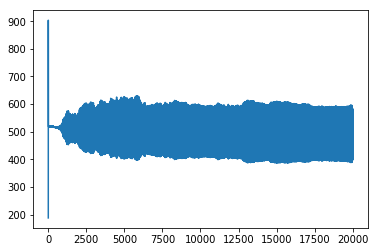

In [33]:
plt.plot(error_list)

In [34]:
Z_Train, A_Train = NN_forward(A0_Train, W, B, AF)

In [35]:
error_Train = find_error(T_Train, A_Train[-1], 'Binary')

In [36]:
error_Train

37.88575180564675

# 5. Make Prediction

In [37]:
Z_Test, A_Test = NN_forward(A0_Test, W, B, AF)

In [38]:
error_Test = find_error(T_Test, A_Test[-1], 'Binary')

In [39]:
error_Test

54.0